# Prerequisites

In [4]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta

is_on_colab = False

In [8]:
# Optiional: Connect to Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    timenow = datetime.now()+timedelta(hours=-7)
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone")
    is_on_colab = True
else:
    print('Running on Local')
    timenow = datetime.now()
    is_on_colab = False

timenow_str = f"{timenow.hour:02d}{timenow.minute:02d}{timenow.month:02d}{timenow.day:02d}"



Running on CoLab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone'
Hypers.Config.data_path='/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone/data'
Hypers.Config.model_path='/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone/model'
Hypers.Config.log_path='/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone/log'


In [ ]:
# Optional: Split data into train and test
merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "dataset_retail_indus.pkl"))
train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True)
print(len(train_dict), len(test_dict))

# LSTM

In [ ]:
import RatingSet
importlib.reload(RatingSet)
import PredictorModel
importlib.reload(PredictorModel)

In [ ]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "train_dict.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "test_dict.pkl"))
print(f"{len(train_dict)}", f"{len(test_dict)}")

# max_seq_len = max(max([len(entries) for entries in train_dict.values()]), max([len(entries) for entries in test_dict.values()]))
max_seq_len = 2
print(f"{max_seq_len=}")

model = PredictorModel.PredictorModel(input_size=len(Hypers.feature_list),
                                      hidden_size=Hypers.Config.hidden_size,
                                      num_layers=max_seq_len,
                                      proj_size=Hypers.Config.proj_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_set, test_set = RatingSet.RatingSet(train_dict), RatingSet.RatingSet(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RatingSet.RatingSet.custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RatingSet.RatingSet.custom_collate_fn)

trainer = Trainer.Trainer(model, criterion, optimizer, device, train_loader, test_loader, max_seq_len)
train_loss, train_accuracy, test_loss, test_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, test_loss, test_accuracy)

In [ ]:
utils.plot_graph(trainer.train_loss_history, trainer.train_acccuracy_history, trainer.test_loss_history, trainer.test_acccuracy_history)

# Regression

In [10]:
import RegressionDataset
importlib.reload(RegressionDataset)
import RegressionModel
importlib.reload(RegressionModel)

<module 'RegressionModel' from '/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone/RegressionModel.py'>

In [11]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "train_dict.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "test_dict.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")

267 79


Vaild Epoch 249: 100%|██████████| 250/250 [22:39<00:00,  5.44s/it, Loss: 5.663]


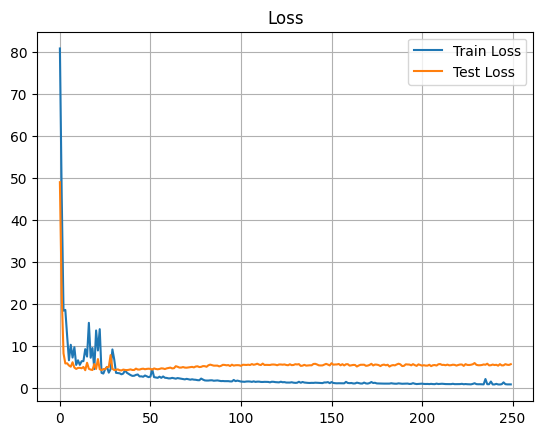

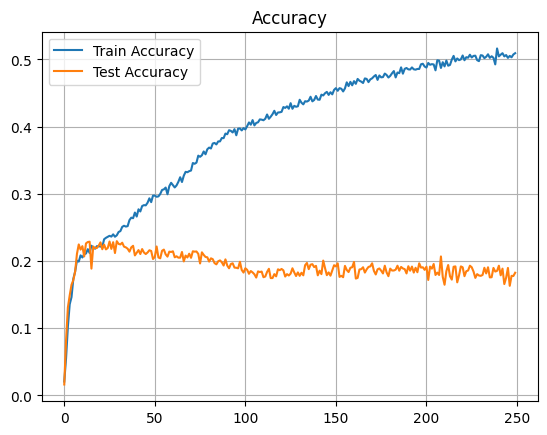

In [12]:
train_set = RegressionDataset.RegressionDataset(train_dict)
test_set = RegressionDataset.RegressionDataset(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)

model = RegressionModel.RegressionModel(input_size=len(Hypers.feature_list))
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          test_loader=test_loader)
train_loss, train_accuracy, test_loss, test_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, test_loss, test_accuracy)